# Growth data analyses

In [146]:
# libraries
library(tidyverse)
library(broom)
library(purrr)
library(car)
library(multcomp)
library(data.table)
library(formattable)
library(ggpubr)
library(cowplot)

# Figure S1:

Here we present the results for the intial strains relative growth rate measurements:

In [134]:
# Read the data
ancestral =  read.csv("../../data/growth_ancestrals.csv")
head(ancestral,n=2)

,Treatment,Linage,Strain,Type,Experiment,Temperature,Max_deriv,Lag,k
,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
1,Media,607,607P,Reference,18_3_18,43,0.001699398,477.6727,0.5504434
2,Media,607,607P,Reference,18_3_18,43,0.001868978,402.4976,0.5556532


In [136]:
# For each experiment
exp43 = ancestral %>% filter(Temperature == 43)
exp15 = ancestral %>% filter(Temperature == 15)

In [141]:
my_comparisons <- list(c("606P","607P") ,c("REL606","REL607"),c("REL606","606P"),c("607P","REL607"))

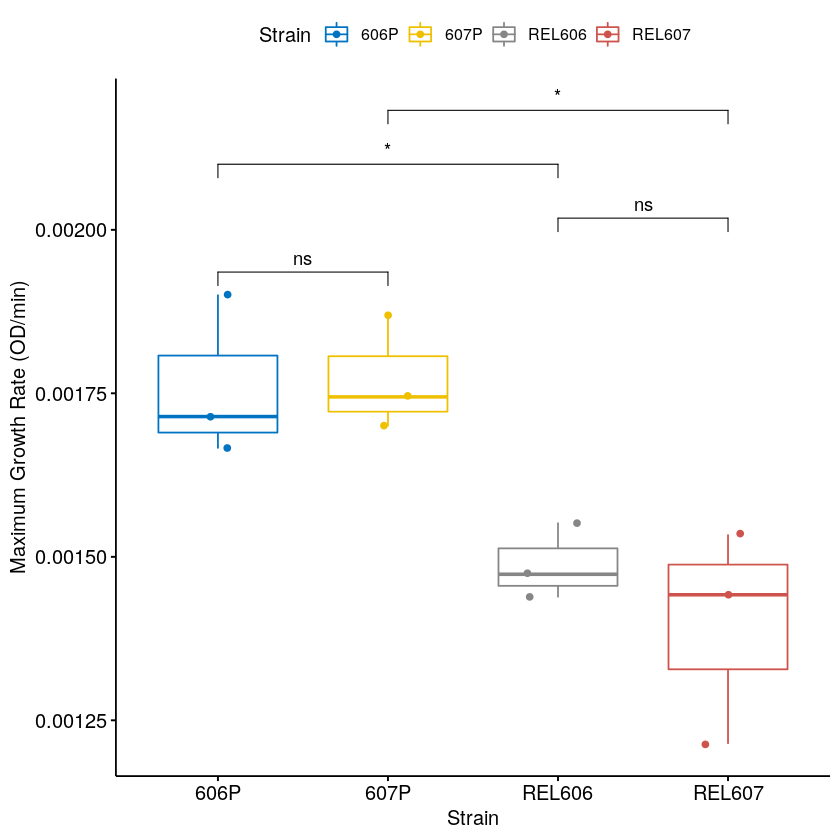

In [197]:
# Plot
#pdf("FigureS1_A.pdf")
ggboxplot(exp43, x = "Strain", y = "Max_deriv",
          color = "Strain", palette = "jco",add="jitter")+
stat_compare_means(comparisons = my_comparisons,method ="t.test",p.adjust.method = "fdr",var.equal
=F,label="p.signif")+ylab("Maximum Growth Rate (OD/min)")
#dev.off()

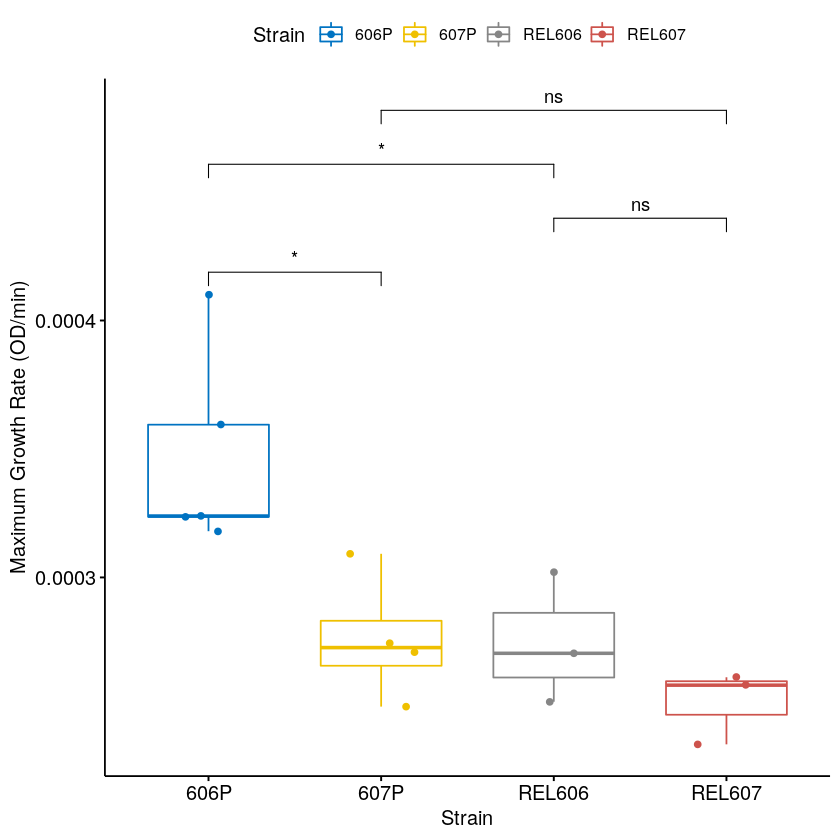

In [199]:
# Plot
#pdf("FigureS1_B.pdf")
ggboxplot(exp15, x = "Strain", y = "Max_deriv",
          color = "Strain", palette = "jco",add="jitter")+
stat_compare_means(comparisons = my_comparisons,method ="t.test",p.adjust.method = "fdr",var.equal
=F,label="p.signif")+ylab("Maximum Growth Rate (OD/min)")+ 
scale_y_continuous(labels = function(x) format(x, scientific = F))
#dev.off()

# Table 1

In [202]:
# Read the data
clones =  read.csv('../../data/growth_strains.csv')
head(clones,n=5)

,Treatment,Linage,Strain,Type,Experiment,Temperature,Max_deriv,Lag,k
,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
1,Media,607,607P,Reference,4_5_17,43,0.001361278,374.8869,0.3902098
2,Media,607,607P,Reference,4_5_17,43,0.001462898,383.5978,0.2912906
3,Media,607,607P,Reference,4_5_17,43,0.001672362,373.3310,0.3517848
4,Random,607,R607-4,Clone,4_5_17,43,0.001704033,497.1238,0.5303027
5,Random,607,R607-4,Clone,4_5_17,43,0.002114594,469.5611,0.2910426


In [203]:
# Calculate the average
sum_clones = clones %>% group_by(Linage,Strain,Treatment,Experiment,Strain,Temperature,Type)  %>%
summarise(Mean = mean(Max_deriv), Std = sd(Max_deriv), Cv = sd(Max_deriv)/mean(Max_deriv), n= n() ) %>% ungroup()
sum_clones$Experiment = as.character(sum_clones$Experiment)
head(sum_clones)

Linage,Strain,Treatment,Experiment,Temperature,Type,Mean,Std,Cv,n
<int>,<fct>,<fct>,<chr>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>
606,606P,Media,11_3_18,43,Reference,0.0021580151,4.063891e-04,0.18831617,3
606,606P,Media,13_5_17,43,Reference,0.0019912839,1.383421e-04,0.06947381,3
606,606P,Media,13_7_17,43,Reference,0.0011670364,8.500562e-05,0.07283887,4
606,606P,Media,26_5_17,43,Reference,0.0011346859,2.079794e-04,0.18329250,3
606,606P,Media,27_5_17,15,Reference,0.0003349167,3.028427e-05,0.09042328,3
606,606P,Media,606_may,15,Reference,0.0003176123,1.165329e-05,0.03669030,3


In [204]:
# Significant
clones = clones %>% distinct() %>% mutate(Group  = factor(paste(Strain,Experiment,Temperature,sep ="_")))
references = clones %>% filter(Type == "Reference")
cloners = clones %>% filter(Type == "Clone") %>% droplevels()
Strain = factor(unique(cloners$Group))
significant = data.frame(vars=double(),k=double(),Strain=factor(),Temperature=integer())
for (i in 1:length(factor(unique(cloners$Group)))){
    strain = Strain[i]
    test = cloners %>% filter(Group == strain)
    ref = references %>% filter(Experiment == test$Experiment[1] & Type == "Reference" & Linage ==  test$Linage[1])
    d = rbind(ref,test)
    # Sanity plot
    filename = paste(strain,test$Temperature[1],sep="_")
    pdf(filename)
    boxplot(d$Max_deriv~d$Type)
    dev.off()
    # t.test
    var_q = bartlett.test(Max_deriv~Type,d)
    var_T = (var_q$p.value>0.05)
    sig = d %>% summarise_each(funs(t.test(.[Type == "Clone"], .[Type == "Reference"],
                                           var.equal=var_T,alternative="greater")$p.value), 
                                           vars = Max_deriv,k)
    sig$Strain = test$Strain[1]
    sig$Temperature = test$Temperature[1]
    significant =  rbind(significant,sig)
    }
Growth = significant %>% dplyr::select(-k) %>% distinct() %>% spread(Temperature, vars)
Growth$Strain = factor(Growth$Strain, levels = c("R606-1", "R606-2", "R606-3", "R606-4","F606-1", "F606-2", "F606-3", "F606-4", "S606-1", "S606-2", "S606-3", "S606-4",
"R607-1", "R607-2", "R607-3", "R607-4","F607-1", "F607-2", "F607-3", "F607-4", "S607-1", "S607-2", "S607-3", "S607-4"))
Growth = Growth %>% arrange(Strain)
Growth

Strain,15,43
<fct>,<dbl>,<dbl>
R606-1,0.6275312633,0.1200203562
R606-2,0.1494577368,0.0052475264
R606-3,NA,0.1969309217
R606-4,0.3217672680,0.0154416461
F606-1,0.5737681293,0.0089207403
F606-2,0.9579287239,0.0012714043
F606-3,0.4382079181,0.0009069110
F606-4,0.1302510608,0.0609585760
S606-1,0.0764494775,0.0297212356


In [205]:
# Replicate table 1
sum_clones$RelFit = 0
for (i in 1:nrow(sum_clones)){
    row_df = sum_clones[i,]
    reference =sum_clones %>% 
    filter(Experiment == as.character(row_df["Experiment"]) & 
           Type == "Reference" & 
           Temperature == as.numeric(row_df["Temperature"]) & 
           Linage == as.character(row_df["Linage"]) )
    sum_clones$RelFit[i] = row_df$Mean/reference$Mean
    
    
}
fitness_table = sum_clones %>% arrange(Linage, Temperature) %>% filter(Type == "Clone")
table1 = fitness_table %>% dplyr::select(Strain,Temperature,RelFit)  %>% distinct() %>% spread(Temperature, RelFit)
table1$Strain = factor(table1$Strain, levels = c("R606-1", "R606-2", "R606-3", "R606-4","F606-1", "F606-2", "F606-3", "F606-4", "S606-1", "S606-2", "S606-3", "S606-4",
"R607-1", "R607-2", "R607-3", "R607-4","F607-1", "F607-2", "F607-3", "F607-4", "S607-1", "S607-2", "S607-3", "S607-4"))
table1 = table1 %>% arrange(Strain)
table1 

Strain,15,43
<fct>,<dbl>,<dbl>
R606-1,0.9372622,1.094937
R606-2,1.0921187,1.203291
R606-3,NA,1.117216
R606-4,1.0193709,1.189927
F606-1,0.9761226,1.237650
F606-2,0.6947790,1.443777
F606-3,1.0308388,1.355158
F606-4,1.2977628,1.175464
S606-1,1.5209109,1.352762


In [206]:
customGreen = "#71CA97"

customRed = "#ff7f7f"

In [207]:
formattable(table1,`Strain`= color_tile(customGreen, customGreen0))

Strain,15,43
<fct>,<dbl>,<dbl>
R606-1,0.9372622,1.094937
R606-2,1.0921187,1.203291
R606-3,NA,1.117216
R606-4,1.0193709,1.189927
F606-1,0.9761226,1.237650
F606-2,0.6947790,1.443777
F606-3,1.0308388,1.355158
F606-4,1.2977628,1.175464
S606-1,1.5209109,1.352762


In [ ]:
library(pheatmap)

In [217]:
lol = table1 %>% drop_na()
lol = as.matrix(lol[,2:3])

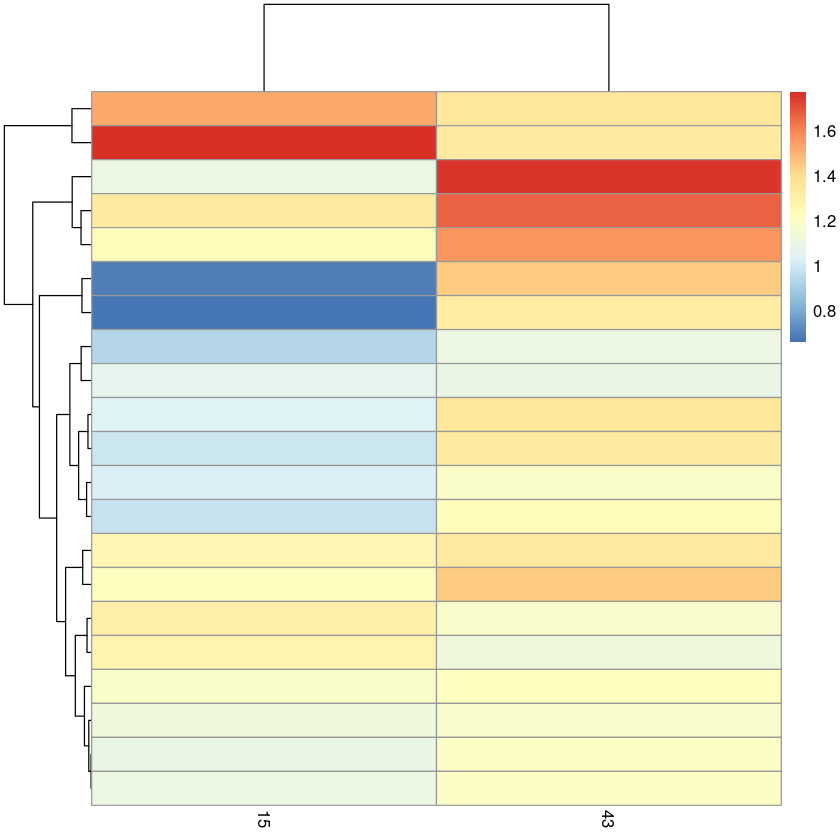

In [218]:

pheatmap(lol)

In [17]:
rownames(my.data) =my.data[,1]


In [21]:
my.data = my.data[,2:3]

In [22]:
x = 1:ncol(my.data)
y = 1:nrow(my.data)
centers <- expand.grid(y,x)
 
#make the plot margins a little bigger
par(mar = c(2,7,4,2))
 
image(x, y, t(my.data),
      col = c(rgb(0,0,1,0.3),rgb(1,0,0,0.3), rgb(1,1,0,0.3)),
      breaks = c(0, 25, 50, 100),
      xaxt = 'n', 
      yaxt = 'n', 
      xlab = '', 
      ylab = '',
      ylim = c(max(y) + 0.5, min(y) - 0.5)
      ) 

#add margin text
mtext(paste(attributes(my.data)$dimnames[[2]],"(%)"), at=1:ncol(my.data), padj = -1)
mtext(attributes(my.data)$dimnames[[1]], at=1:nrow(my.data), side = 2, las = 1, adj = 1.2)

#add black lines
abline(h=y + 0.5)
abline(v=x + 0.5)


ERROR: Error in image.default(x, y, t(my.data), col = c(rgb(0, 0, 1, 0.3), rgb(1, : 'z' must be numeric or logical
